# Implementation For Asia
## State Variable:

- Prices: MSCI Asia (Bloomberg)
- Volatility: realised vol on MSCI Asia
- 10 year rate: 10 year Japan (FRED)
- 3 month rate: 3 month Japan bond (FRED)
- Oil: Dubai Crude Oil (Bloomberg)
- Copper: Copper futures prices (Bloomberg)

Used also Fama French Factors to evaluate the performance for now,

## Results: 
The signal seems to hold in this market too, Maha distance seems also to improve a lot the signal here (higher SR) for Q1-Q2-Q3.

In [44]:
import os
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
from pandas.tseries.offsets import MonthEnd
from matplotlib.patches import Rectangle
from numpy.linalg import inv, LinAlgError

data_asia= pd.read_excel("Regimes\Data\Asia\Asia State Var.xlsx")
data_asia.head()

,Date,MSCI Asia,China10y,China3m,South Korea10y,South Korea3y,PGCRDUBA Index,Hang Senk Vol,Hang Senk Index
0,1928-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1929-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1929-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1929-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1929-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


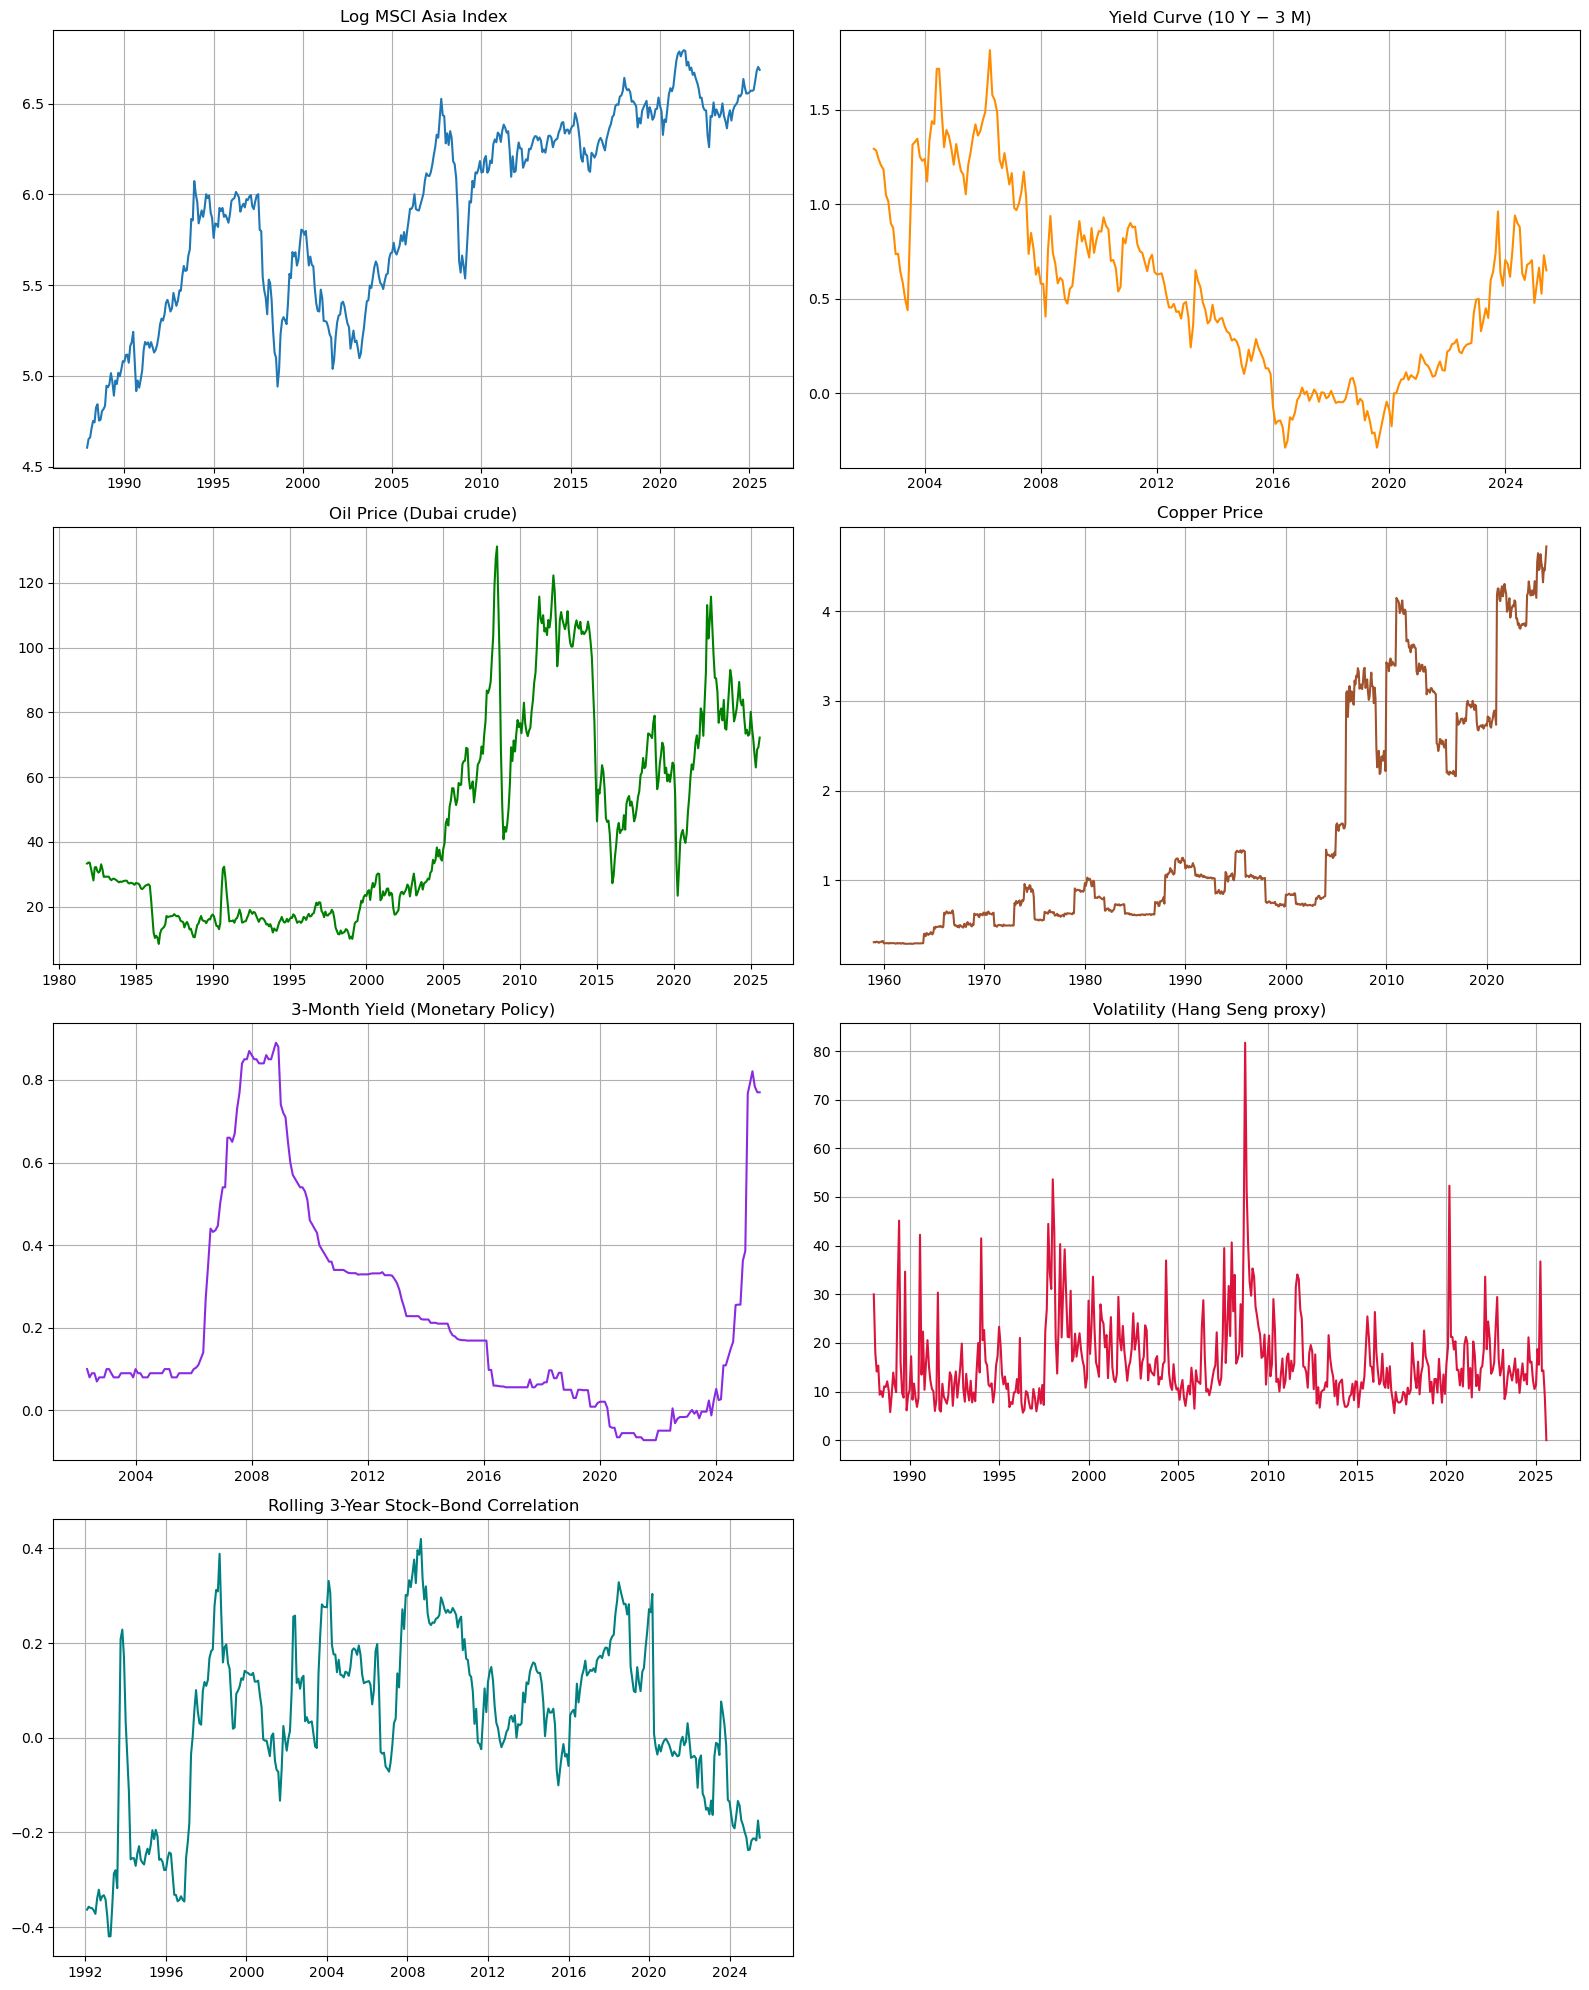

In [45]:
df = data_asia.copy()
df["Date"]  = pd.to_datetime(df["Date"])
df["Month"] = df["Date"].dt.to_period("M")        
log = np.log                                      

# ---------------------------------------------------------------
# 1. MSCI Asia (market level, returns, log-price)
# ---------------------------------------------------------------
df["ret_mkt"] = log(df["MSCI Asia"]).diff()

mkt_monthly = (df.groupby("Month")
                 .tail(1)                           
                 .reset_index(drop=True))

mkt_monthly["Asia_Return"]   = log(mkt_monthly["MSCI Asia"]).diff()
mkt_monthly["Log_AsiaPrice"] = log(mkt_monthly["MSCI Asia"])

var_mkt_asia = mkt_monthly[["Month",
                            "MSCI Asia",
                            "Asia_Return",
                            "Log_AsiaPrice"]].copy()


PATH_10Y = "Regimes\Data\Asia\Japan10y.xlsx"
PATH_3M  = "Regimes\Data\Asia\Japan3month.xlsx"


teny = (pd.read_excel(PATH_10Y, parse_dates=["Date"])
          .rename(columns=str.strip))                 # trim column names

teny["TenYear"] = pd.to_numeric(teny["TenYear"], errors="coerce")
teny["Month"]   = teny["Date"].dt.to_period("M")

tenyear_monthly = (teny.groupby("Month")["TenYear"]
                     .mean()                         
                     .reset_index())

thrmo = (pd.read_excel(PATH_3M, parse_dates=["Date"])
           .rename(columns=str.strip))

thrmo["ThreeMonth"] = pd.to_numeric(thrmo["ThreeMonth"], errors="coerce")
thrmo["Month"]      = thrmo["Date"].dt.to_period("M")

var_3m_asia = (thrmo.groupby("Month")["ThreeMonth"]
                 .mean()
                 .reset_index())

# ---------------------------------------------------------------
# 4. Yield-curve variables
# ---------------------------------------------------------------
merged_asia = (tenyear_monthly
                 .merge(var_3m_asia, on="Month", how="inner")
                 .sort_values("Month"))

merged_asia["YieldCurve"]  = merged_asia["TenYear"] - merged_asia["ThreeMonth"]
merged_asia["YieldChange"] = merged_asia["TenYear"].diff()

# ---------------------------------------------------------------
# 5. Crude Oil (Dubai)
# ---------------------------------------------------------------
df["PGCRDUBA Index"] = pd.to_numeric(df["PGCRDUBA Index"], errors="coerce")

oil_monthly_asia = (df.groupby("Month")["PGCRDUBA Index"]
                      .mean()
                      .reset_index()
                      .rename(columns={"PGCRDUBA Index": "Oil Price"}))

# ---------------------------------------------------------------
# 6. Copper  
# ---------------------------------------------------------------

var_copper = pd.read_csv(
    "Regimes\Data\Original Reproduction\copper-prices-historical-chart-data.csv")
var_copper.rename(columns={var_copper.columns[0]: "Date",
                           var_copper.columns[1]: "Copper"},
                  inplace=True)
var_copper["Date"]   = pd.to_datetime(var_copper["Date"],
                                      dayfirst=True, errors="coerce")
var_copper["Copper"] = pd.to_numeric(var_copper["Copper"], errors="coerce")
var_copper["Month"]  = var_copper["Date"].dt.to_period("M")
copper_monthly = (var_copper
                  .groupby("Month")["Copper"]
                  .mean()
                  .reset_index())


# ---------------------------------------------------------------
# 7. Volatility
# ---------------------------------------------------------------
def realised_vol(series):

    return series.std(ddof=0) * np.sqrt(252) * 100     

vol_monthly_asia = (df.groupby("Month")["ret_mkt"]
                      .agg(realised_vol)
                      .reset_index()
                      .rename(columns={"ret_mkt": "VolProxy"}))

combined_vol_asia = vol_monthly_asia.copy()

# ---------------------------------------------------------------
# 8.  Stock–Bond correlation  (MSCI Asia monthly ret  vs  Δ10-y JGB)
# ---------------------------------------------------------------

eq_monthly = (df.groupby("Month")["ret_mkt"]
                .sum()                    
                .reset_index()
                .rename(columns={"ret_mkt": "EquityRet"}))

tenyear_monthly = tenyear_monthly.copy()  
tenyear_monthly["d_y"] = tenyear_monthly["TenYear"].diff() / 100.0   

sb_month = (eq_monthly
              .merge(tenyear_monthly[["Month", "d_y"]], on="Month", how="inner")
              .dropna(subset=["d_y"]))

window_m = 36
sb_month["StockBondCorr"] = (
    sb_month["EquityRet"]
      .rolling(window_m, min_periods=window_m)
      .corr(sb_month["d_y"])
)

var_correl_asia = sb_month.dropna(subset=["StockBondCorr"])[
                    ["Month", "StockBondCorr"]
                  ].reset_index(drop=True)

fig, axes = plt.subplots(4, 2, figsize=(16, 20))
fig.subplots_adjust(hspace=0.4, wspace=0.3)
axes = axes.flatten()

# 1. Log MSCI Asia
var_mkt_latest_asia = var_mkt_asia.drop_duplicates("Month", keep="last")
axes[0].plot(
    var_mkt_latest_asia["Month"].dt.to_timestamp(),
    np.log(var_mkt_latest_asia["MSCI Asia"]),
    label="Log MSCI Asia"
)
axes[0].set_title("Log MSCI Asia Index")
axes[0].grid()

# 2. Yield Curve (10-y − 3-m)  
axes[1].plot(
    merged_asia["Month"].dt.to_timestamp(),
    merged_asia["YieldCurve"],
    label="Yield Curve",
    color="darkorange"
)
axes[1].set_title("Yield Curve (10 Y − 3 M)")
axes[1].grid()

# 3. Dubai Crude Oil
axes[2].plot(
    oil_monthly_asia["Month"].dt.to_timestamp(),
    oil_monthly_asia["Oil Price"],
    label="Oil Price",
    color="green"
)
axes[2].set_title("Oil Price (Dubai crude)")
axes[2].grid()

# 4. Copper 
axes[3].plot(
    copper_monthly["Month"].dt.to_timestamp(),
    copper_monthly["Copper"],
    label="Copper Price",
    color="sienna"
)
axes[3].set_title("Copper Price")
axes[3].grid()

# 5. 3-Month rate 
axes[4].plot(
    var_3m_asia["Month"].dt.to_timestamp(how="end"),
    var_3m_asia["ThreeMonth"],
    label="3 M Yield",
    color="blueviolet"
)
axes[4].set_title("3-Month Yield (Monetary Policy)")
axes[4].grid()

# 6. Volatility 
axes[5].plot(
    combined_vol_asia["Month"].dt.to_timestamp(),
    combined_vol_asia["VolProxy"],
    label="Vol Proxy",
    color="crimson"
)
axes[5].set_title("Volatility (Hang Seng proxy)")
axes[5].grid()

# 7. Rolling 3-Year Stock–Bond Correlation 
axes[6].plot(
    var_correl_asia["Month"].dt.to_timestamp(how="end"),
    var_correl_asia["StockBondCorr"],
    label="Stock–Bond Corr.",
    color="teal"
)
axes[6].set_title("Rolling 3-Year Stock–Bond Correlation")
axes[6].grid()

axes[7].axis("off")

plt.tight_layout()
plt.show()


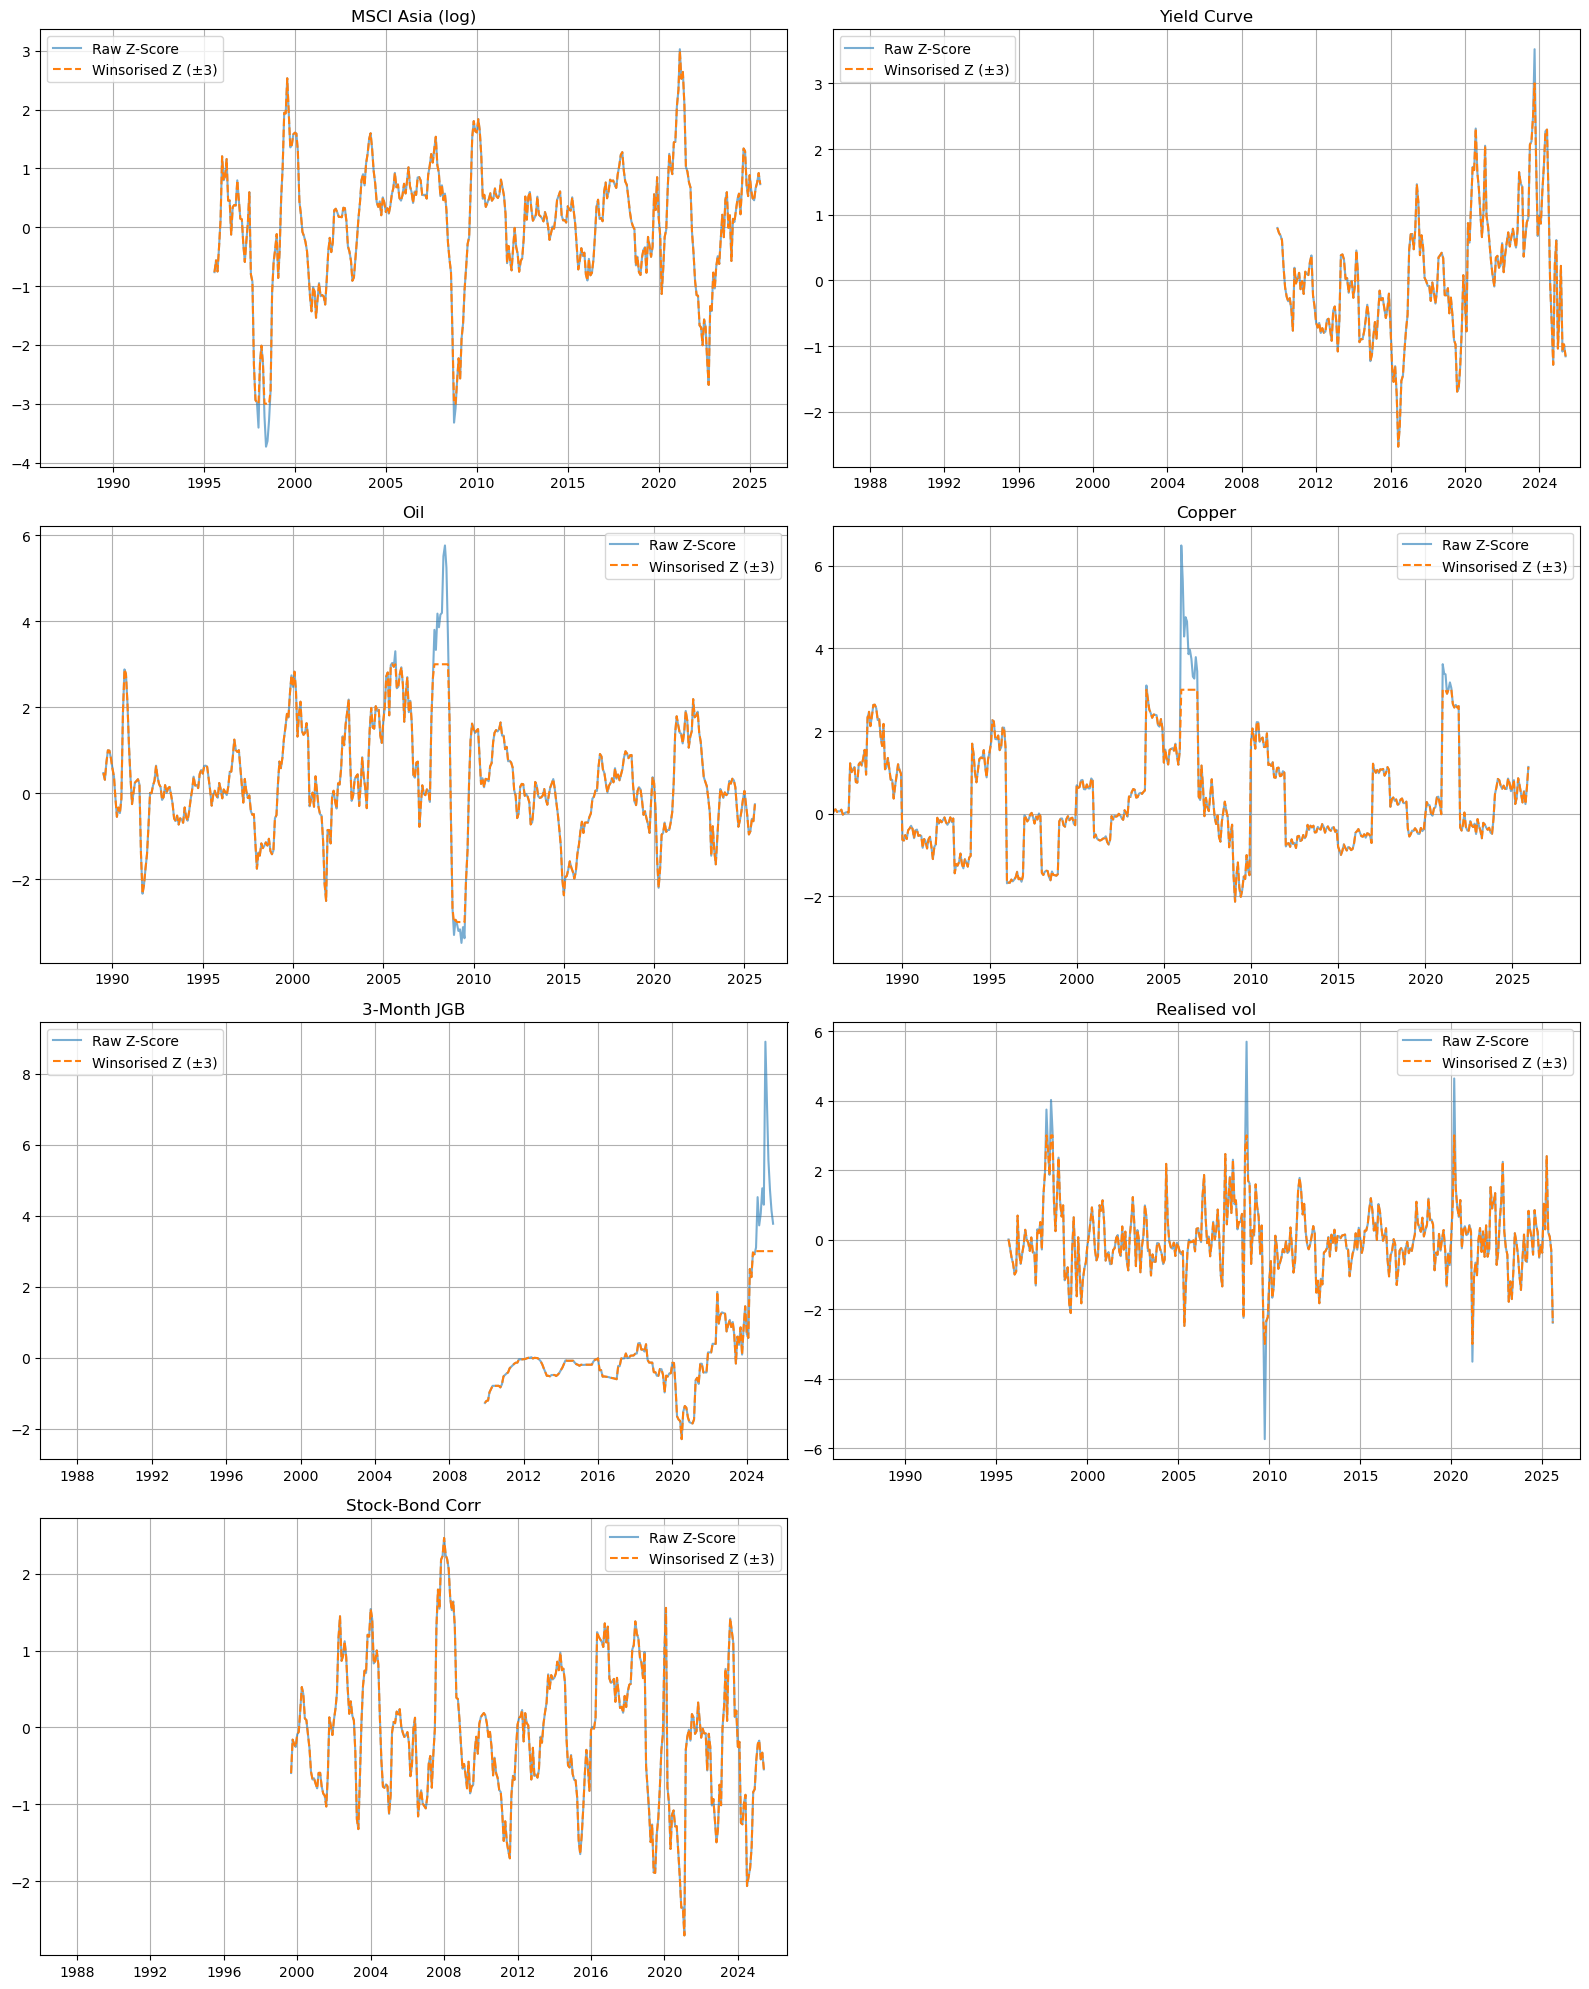

In [22]:
def compute_z_and_winsorized(df, date_col, value_col, window_months=120):
    df = df.copy().sort_values(date_col)
    df["Diff12"]  = df[value_col] - df[value_col].shift(12)
    df["RollStd"] = (df["Diff12"]
                     .shift(1)
                     .rolling(window_months, min_periods=80)
                     .std())
    df["ZScore"]  = df["Diff12"] / df["RollStd"]
    df["ZScoreWinsorized"] = df["ZScore"].clip(-3, 3)
    return df[[date_col, "ZScore", "ZScoreWinsorized"]]


series_info_asia = {
    "MSCI Asia (log)":        ("asia_log",      var_mkt_asia,     "Month", "Log_AsiaPrice"),
    "Yield Curve":            ("yield_curve",   merged_asia,      "Month", "YieldCurve"),
    "Oil":                    ("oil",           oil_monthly_asia, "Month", "Oil Price"),
    "Copper":                 ("copper",        copper_monthly,   "Month", "Copper"),
    "3-Month JGB":            ("three_month",   var_3m_asia,      "Month", "ThreeMonth"),
    "Realised vol":           ("vol",           combined_vol_asia,"Month", "VolProxy"),
    "Stock-Bond Corr":        ("sb_corr",       var_correl_asia,  "Month", "StockBondCorr"),
}


fig, axes = plt.subplots(4, 2, figsize=(16, 20))
axes = axes.flatten()

for i, (title, (_, df_ser, date_col, value_col)) in enumerate(series_info_asia.items()):
    z_df = compute_z_and_winsorized(df_ser, date_col, value_col)
    axes[i].plot(z_df[date_col].dt.to_timestamp(), z_df["ZScore"],
                 label="Raw Z-Score", alpha=0.6)
    axes[i].plot(z_df[date_col].dt.to_timestamp(), z_df["ZScoreWinsorized"],
                 label="Winsorised Z (±3)", ls="--")
    axes[i].set_title(title)
    axes[i].set_xlim(left=pd.Timestamp("1986-01-01"))
    axes[i].grid(True)
    axes[i].legend()

for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


In [23]:
market_monthly_asia = (var_mkt_asia
    .loc[:, ["Month", "Log_AsiaPrice"]]
    .rename(columns={"Log_AsiaPrice": "Value"}))

yield_monthly_asia  = (merged_asia
    .loc[:, ["Month", "YieldCurve"]]
    .rename(columns={"YieldCurve": "Value"}))

oil_monthly_clean_asia    = oil_monthly_asia.rename(columns={"Oil Price": "Value"})
copper_monthly_clean_asia = copper_monthly.rename(columns={"Copper": "Value"})

monthly_3m_asia = (var_3m_asia
    .loc[:, ["Month", "ThreeMonth"]]
    .rename(columns={"ThreeMonth": "Value"}))

vol_monthly_clean_asia = combined_vol_asia.rename(columns={"VolProxy": "Value"})

stockbond_monthly_asia = (var_correl_asia
    .loc[:, ["Month", "StockBondCorr"]]
    .rename(columns={"StockBondCorr": "Value"}))

series_dict_asia = {
    "Market":              market_monthly_asia,
    "Yield curve":         yield_monthly_asia,
    "Oil":                 oil_monthly_clean_asia,
    "Copper":              copper_monthly_clean_asia,
    "3-M JGB":             monthly_3m_asia,
    "Realised vol":        vol_monthly_clean_asia,
    "Stock-Bond Corr":     stockbond_monthly_asia,
}


series_info_asia = {
    "MSCI Asia (log)":  ("asia_log",   var_mkt_asia,     "Month", "Log_AsiaPrice"),
    "Yield curve":      ("yield_curve",merged_asia,      "Month", "YieldCurve"),
    "Oil":              ("oil",        oil_monthly_asia, "Month", "Oil Price"),
    "Copper":           ("copper",     copper_monthly,   "Month", "Copper"),
    "3-M JGB":          ("three_month",var_3m_asia,      "Month", "ThreeMonth"),
    "Realised vol":     ("vol",        combined_vol_asia,"Month", "VolProxy"),
    "Stock-Bond Corr":  ("sb_corr",    var_correl_asia,  "Month", "StockBondCorr"),
}

rows   = []
lags   = [1, 3, 12, 36, 120]   # months

for title, (_, df_src, date_col, value_col) in series_info_asia.items():
    zdf = (compute_z_and_winsorized(df_src, date_col, value_col)
           .dropna(subset=["ZScoreWinsorized"])
           .reset_index(drop=True))

    if len(zdf) < max(lags) + 1:
        acs    = [np.nan] * len(lags)
        mean_z = np.nan
        std_z  = np.nan
    else:
        acs    = [zdf["ZScoreWinsorized"].autocorr(lag=l) for l in lags]
        mean_z = zdf["ZScoreWinsorized"].mean()
        std_z  = zdf["ZScoreWinsorized"].std(ddof=1)

    rows.append({
        "Variable":     title,
        "1 month":      acs[0],
        "3 month":      acs[1],
        "12 month":     acs[2],
        "3 year":       acs[3],
        "10 year":      acs[4],
        "monthly mean": mean_z,
        "std":          std_z,
        "frequency":    "monthly",
    })

summary_table_asia = (pd.DataFrame(rows)
    .loc[:, ["Variable", "1 month", "3 month", "12 month",
             "3 year", "10 year", "monthly mean", "std", "frequency"]])

numeric_cols = ["1 month", "3 month", "12 month",
                "3 year", "10 year", "monthly mean", "std"]
summary_table_asia[numeric_cols] = summary_table_asia[numeric_cols].round(2)
summary_table_asia


,Variable,1 month,3 month,12 month,3 year,10 year,monthly mean,std,frequency
0,MSCI Asia (log),0.93,0.74,-0.27,0.23,0.19,0.07,1.04,monthly
1,Yield curve,0.87,0.64,-0.03,0.36,0.09,0.05,0.93,monthly
2,Oil,0.93,0.71,-0.13,0.06,-0.08,0.25,1.24,monthly
3,Copper,0.91,0.75,0.08,-0.08,0.02,0.22,1.19,monthly
4,3-M JGB,0.96,0.91,0.53,-0.06,0.55,0.03,1.08,monthly
5,Realised vol,0.58,0.25,-0.41,-0.01,0.12,0.01,0.94,monthly
6,Stock-Bond Corr,0.90,0.66,-0.30,-0.38,0.33,-0.11,0.89,monthly


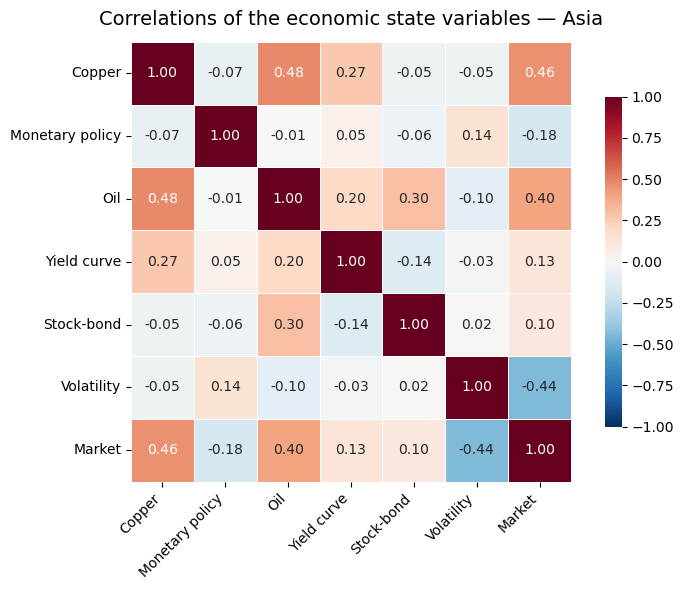

In [24]:

z_market  = (compute_z_and_winsorized(market_monthly_asia,  "Month", "Value")
               .rename(columns={"ZScoreWinsorized": "Market"})[["Month","Market"]])

z_yield   = (compute_z_and_winsorized(yield_monthly_asia,   "Month", "Value")
               .rename(columns={"ZScoreWinsorized": "Yield curve"})[["Month","Yield curve"]])

z_oil     = (compute_z_and_winsorized(oil_monthly_clean_asia,"Month","Value")
               .rename(columns={"ZScoreWinsorized": "Oil"})[["Month","Oil"]])

z_copper  = (compute_z_and_winsorized(copper_monthly_clean_asia,"Month","Value")
               .rename(columns={"ZScoreWinsorized": "Copper"})[["Month","Copper"]])

z_3m      = (compute_z_and_winsorized(monthly_3m_asia,       "Month", "Value")
               .rename(columns={"ZScoreWinsorized": "Monetary policy"})[["Month","Monetary policy"]])

z_vol     = (compute_z_and_winsorized(vol_monthly_clean_asia,"Month","Value")
               .rename(columns={"ZScoreWinsorized": "Volatility"})[["Month","Volatility"]])

z_sb      = (compute_z_and_winsorized(stockbond_monthly_asia,"Month","Value")
               .rename(columns={"ZScoreWinsorized": "Stock-bond"})[["Month","Stock-bond"]])

df_period_asia = (z_market
    .merge(z_yield, on="Month", how="outer")
    .merge(z_oil,   on="Month", how="outer")
    .merge(z_copper,on="Month", how="outer")
    .merge(z_3m,    on="Month", how="outer")
    .merge(z_vol,   on="Month", how="outer")
    .merge(z_sb,    on="Month", how="outer"))

corr_mat_asia = df_period_asia.drop(columns="Month").corr()

row_order = [
    "Copper",
    "Monetary policy",
    "Oil",
    "Yield curve",
    "Stock-bond",
    "Volatility",
    "Market",
]
corr_mat_asia = corr_mat_asia.loc[row_order, row_order]

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_mat_asia,
    annot=True, fmt=".2f",
    center=0, cmap="RdBu_r",
    vmin=-1, vmax=1,
    square=True, linewidths=0.5,
    cbar_kws={"shrink": 0.75},
)
plt.title("Correlations of the economic state variables — Asia",
          fontsize=14, pad=12)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [7]:
def find_similar_months(
    df_period: pd.DataFrame,
    target: str,
    exclude_last_n: int = 36,
    bottom_pct: float = 0.15
) -> pd.DataFrame:
    
    T_period = pd.Period(target, freq='M')

    
    cutoff_period = T_period - exclude_last_n  

    mask = df_period.index <= cutoff_period

    df_candidates = df_period.loc[mask].copy()

    df_candidates = df_candidates.dropna(how='any')

    z_T = df_period.loc[T_period].values   

    mat = df_candidates.values               
    diffs = mat - z_T.reshape(1, -1)        
    sq    = diffs**2
    dist  = np.sqrt(sq.sum(axis=1))          

    out = pd.DataFrame({
        'Distance': dist
    }, index=df_candidates.index)

    out = out.sort_values('Distance', ascending=True)
    out['Rank'] = np.arange(1, len(out) + 1)
    n_select = int(np.floor(bottom_pct * len(out)))
    n_select = max(n_select, 1)  
    out['IsBottom'] = False
    out.iloc[:n_select, out.columns.get_indexer(['IsBottom'])] = True

    result_df = out.reset_index().rename(columns={'index': 'Month'})

    return result_df

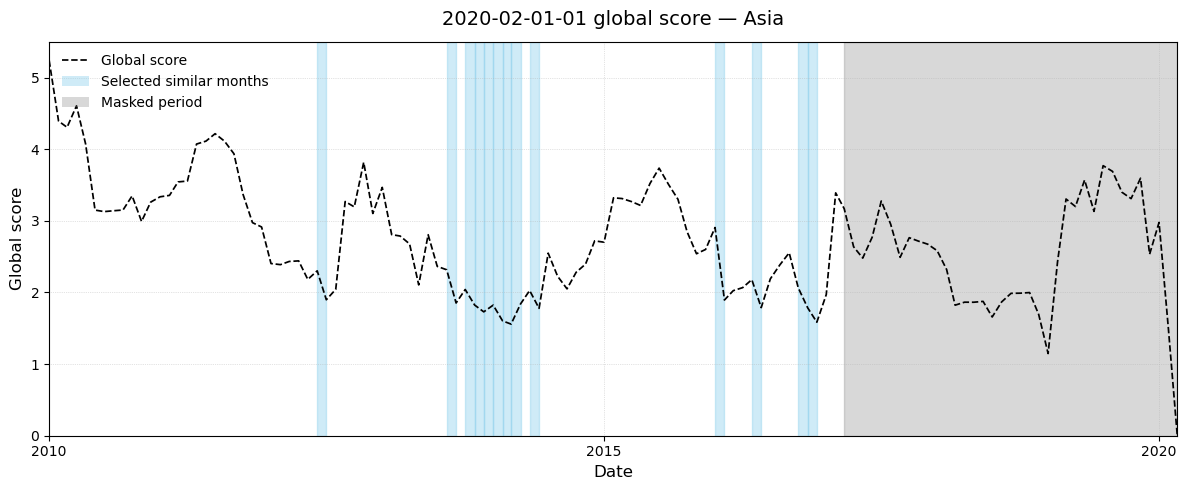

In [26]:

if "Month" in df_period_asia.columns:
    df_period_asia = df_period_asia.set_index("Month")

target_month   = "2020-02-01"  
bottom_pct     = 0.15           
exclude_last_n = 36             


sim_tbl_full = find_similar_months(
    df_period      = df_period_asia,
    target         = target_month,
    exclude_last_n = 0,             
    bottom_pct     = bottom_pct,
)

sim_tbl_masked = find_similar_months(
    df_period      = df_period_asia,
    target         = target_month,
    exclude_last_n = exclude_last_n,
    bottom_pct     = bottom_pct,
)

ts_dist = (sim_tbl_full
             .set_index("Month")["Distance"]
             .sort_index()
             .rename("Global score"))
ts_dist.index = ts_dist.index.to_timestamp(how="end")

selected = sim_tbl_masked[sim_tbl_masked["IsBottom"]].copy()
selected["start"] = selected["Month"].dt.to_timestamp(how="start")
selected["end"]   = selected["Month"].dt.to_timestamp(how="end")

T_period      = pd.Period(target_month, freq="M")
cutoff_period = T_period - exclude_last_n
mask_start_ts = (cutoff_period + 1).to_timestamp(how="start")
mask_end_ts   =  T_period.to_timestamp(how="end")


plt.figure(figsize=(12, 5))
ax = plt.gca()

ax.plot(ts_dist.index, ts_dist.values,
        linestyle="--", color="black", linewidth=1.25,
        label="Global score")

for _, row in selected.iterrows():
    ax.axvspan(row["start"], row["end"], color="skyblue", alpha=0.4)

ax.axvspan(mask_start_ts, mask_end_ts, color="gray", alpha=0.3)

proxy_sim  = Rectangle((0, 0), 1, 1, facecolor="skyblue", alpha=0.4)
proxy_mask = Rectangle((0, 0), 1, 1, facecolor="gray",    alpha=0.3)
ax.legend(handles=[ax.lines[0], proxy_sim, proxy_mask],
          labels=["Global score",
                  "Selected similar months",
                  "Masked period"],
          loc="upper left", frameon=False)

ax.set_title(f"{target_month}-01 global score — Asia", fontsize=14, pad=12)
ax.set_ylabel("Global score", fontsize=12)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylim(bottom=0)
ax.set_xlim(left=ts_dist.index.min(), right=ts_dist.index.max())
ax.grid(which="major", linestyle=":", linewidth=0.5, alpha=0.7)
ax.xaxis.set_major_locator(mdates.YearLocator(base=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [46]:
ff_5f = pd.read_csv("Regimes\Data\Asia\Asia_Pacific_ex_Japan_5_Factors.csv",skiprows=3,engine='python').rename(columns={"Unnamed: 0": "Date"}) 
ff_mom = pd.read_csv("Regimes\Data\Asia\Asia_Pacific_ex_Japan_MOM_Factor.csv",skiprows=3,engine='python').rename(columns={"Unnamed: 0": "Date"}) 


In [30]:

concat_fff_asia = (
    pd.merge(ff_5f, ff_mom, on="Date", how="inner")     
      .rename(columns={"WML": "Mom"})    # clarify cols
      .assign(Date=lambda d: d["Date"].astype(str).str.strip())
      .loc[lambda d: d["Date"].str.fullmatch(r"\d{6}")]        
)


concat_fff_asia["Month"] = pd.to_datetime(concat_fff_asia["Date"], format="%Y%m").dt.to_period("M")
concat_fff_asia = concat_fff_asia.set_index("Month").drop(columns="Date").sort_index()

factor_cols = ["Mkt-RF", "SMB", "HML", "RMW", "CMA", "Mom"]
concat_fff_asia[factor_cols] = concat_fff_asia[factor_cols].apply(pd.to_numeric, errors="coerce") / 100
concat_fff_asia["RF"]        = pd.to_numeric(concat_fff_asia["RF"], errors="coerce") / 100

print(concat_fff_asia.head())


         Mkt-RF     SMB     HML     RMW     CMA      RF     Mom
Month                                                          
1991-01  0.0528 -0.0352  0.0134  0.0084 -0.0006  0.0052  0.0128
1991-03  0.0228 -0.0100  0.0180 -0.0157  0.0136  0.0044  0.0264
1991-06 -0.0064  0.0040 -0.0029  0.0007  0.0148  0.0042 -0.0017
1991-09  0.0081  0.0177  0.0180 -0.0011  0.0017  0.0046  0.0155
1991-10  0.0377  0.0166  0.0129 -0.0057 -0.0124  0.0042  0.0020


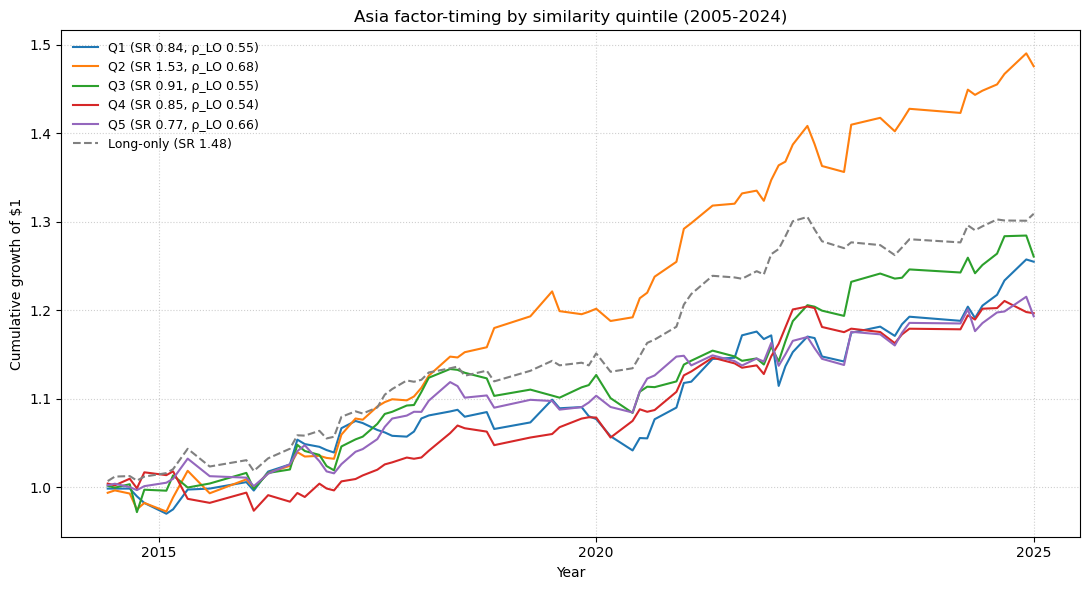

In [31]:
lookback_gap = 36
factors      = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'Mom']
colors       = {1:"tab:blue", 2:"tab:orange", 3:"tab:green",
                4:"tab:red", 5:"tab:purple"}

BACKTEST_START = pd.Period('2014-01', freq='M')
BACKTEST_END   = pd.Period('2024-12', freq='M')

def quintile_members(df_period: pd.DataFrame, target_per: pd.Period):
    full = (find_similar_months(df_period, str(target_per),
                                exclude_last_n=lookback_gap,
                                bottom_pct=1.0)
            .sort_values('Distance'))

    n = len(full)
    if n == 0:
        return {q: np.array([]) for q in range(1, 6)}

    k20         = int(0.20 * n)
    q1          = full.iloc[:k20]['Month'].to_numpy()
    q5          = full.iloc[-k20:]['Month'].to_numpy()
    mid         = full.iloc[k20:-k20]['Month'].to_numpy()
    q2, q3, q4  = np.array_split(mid, 3)

    return {1: q1, 2: q2, 3: q3, 4: q4, 5: q5}

def signal_for_quintile(df_period, target_per, quintile):
    months = quintile_members(df_period, target_per)[quintile]
    if len(months) == 0:
        return {f: 0 for f in factors}

    idx   = pd.PeriodIndex(months, freq='M') + 1   
    signs = {}
    for f in factors:
        rets     = concat_fff_asia.loc[concat_fff_asia.index.intersection(idx), f]
        signs[f] = np.sign(rets.mean()) if not rets.empty else 0
    return signs

if "Month" in df_period_asia.columns:
    df_period_asia = df_period_asia.set_index("Month")

first_possible = df_period_asia.index.min() + (lookback_gap + 1)
hist_start     = max(BACKTEST_START, first_possible)
hist_end       = min(BACKTEST_END,   concat_fff_asia.index.max())

all_months = concat_fff_asia.index.sort_values()
start_idx  = next(i for i, p in enumerate(all_months) if p >= hist_start)
stop_idx   = next(i for i, p in enumerate(all_months) if p >  hist_end) - 1

returns_by_q = {q: [] for q in range(1, 6)}

for i in range(start_idx, stop_idx):
    cur_per, nxt_per = all_months[i], all_months[i+1]
    r = concat_fff_asia.loc[nxt_per, factors]

    for q in range(1, 6):
        sig = signal_for_quintile(df_period_asia, cur_per, q)
        ret = np.mean([sig[f] * r[f] for f in factors])
        returns_by_q[q].append({'Date': nxt_per, 'Return': ret})

q_df = {q: pd.DataFrame(lst).set_index('Date') for q, lst in returns_by_q.items()}

common_idx = q_df[1].dropna().index
for q in range(2, 6):
    common_idx = common_idx.intersection(q_df[q].dropna().index)

first_trd = common_idx.min()

for q in q_df:
    q_df[q] = q_df[q].loc[first_trd:]

long_only = (
    concat_fff_asia[factors]
      .mean(axis=1)
      .loc[first_trd:]
      .reindex(q_df[1].index)
      .dropna()
)

ann_sr  = lambda x: (x.mean() / x.std()) * np.sqrt(12) if x.std() != 0 else np.nan
corr_lo = lambda x: x.corr(long_only)

stats = {q: (ann_sr(df['Return']), corr_lo(df['Return'])) for q, df in q_df.items()}
sr_lo = ann_sr(long_only)

cum = lambda x: (1 + x).cumprod()

plt.figure(figsize=(11, 6))
for q in range(1, 6):
    plt.plot(q_df[q].index.to_timestamp(how='end'),
             cum(q_df[q]['Return']),
             color=colors[q],
             label=f"Q{q} (SR {stats[q][0]:.2f}, ρ_LO {stats[q][1]:.2f})")

plt.plot(q_df[1].index.to_timestamp(how='end'),
         cum(long_only), color='gray', ls='--',
         label=f"Long-only (SR {sr_lo:.2f})")

plt.title("Asia factor-timing by similarity quintile (2005-2024)")
plt.xlabel("Year")
plt.ylabel("Cumulative growth of $1")
plt.legend(frameon=False, fontsize=9)
plt.grid(ls=":", alpha=.6)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(base=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.tight_layout()
plt.show()


In [19]:
def find_similar_months_maha(
    df_period: pd.DataFrame,
    target: str,
    exclude_last_n: int = 36,
    bottom_pct: float = 0.15,
    ridge: float = 1e-8         
) -> pd.DataFrame:
    
    T_period = pd.Period(target, freq="M")

    cutoff_period = T_period - exclude_last_n
    df_candidates = (df_period
                     .loc[df_period.index <= cutoff_period]
                     .dropna(how="any")
                     .copy())

    if df_candidates.empty:
        raise ValueError("No candidate months left after masking NA / look-back.")

    X = df_candidates.values
    try:
        inv_cov = inv(np.cov(X, rowvar=False))
    except LinAlgError:
        Σ = np.cov(X, rowvar=False)
        Σ += ridge * np.eye(Σ.shape[0])
        inv_cov = inv(Σ)

    x_T = df_period.loc[T_period].values.reshape(1, -1)
    diffs = X - x_T                             # (n, k)
    d2    = np.einsum("ij,jk,ik->i", diffs, inv_cov, diffs)  
    dist  = np.sqrt(d2)

    out = (pd.DataFrame({"Distance": dist}, index=df_candidates.index)
             .sort_values("Distance"))
    out["Rank"] = np.arange(1, len(out) + 1)

    n_select = max(int(np.floor(bottom_pct * len(out))), 1)
    out["IsBottom"] = False
    out.iloc[:n_select, out.columns.get_loc("IsBottom")] = True

    return out.reset_index().rename(columns={"index": "Month"})


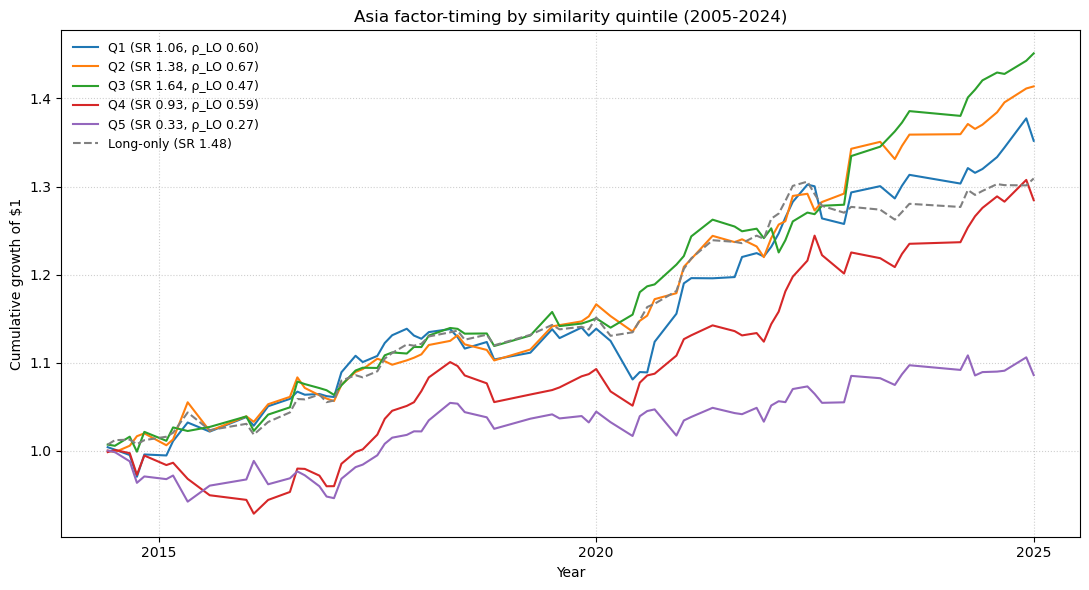

In [33]:
lookback_gap = 36
factors      = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'Mom']
colors       = {1:"tab:blue", 2:"tab:orange", 3:"tab:green",
                4:"tab:red", 5:"tab:purple"}

BACKTEST_START = pd.Period('2014-01', freq='M')
BACKTEST_END   = pd.Period('2024-12', freq='M')

def quintile_members(df_period: pd.DataFrame, target_per: pd.Period):
    full = (find_similar_months_maha(df_period, str(target_per),
                                exclude_last_n=lookback_gap,
                                bottom_pct=1.0)
            .sort_values('Distance'))

    n = len(full)
    if n == 0:
        return {q: np.array([]) for q in range(1, 6)}
    k20         = int(0.20 * n)
    q1          = full.iloc[:k20]['Month'].to_numpy()
    q5          = full.iloc[-k20:]['Month'].to_numpy()
    mid         = full.iloc[k20:-k20]['Month'].to_numpy()
    q2, q3, q4  = np.array_split(mid, 3)

    return {1: q1, 2: q2, 3: q3, 4: q4, 5: q5}

def signal_for_quintile(df_period, target_per, quintile):
    months = quintile_members(df_period, target_per)[quintile]
    if len(months) == 0:
        return {f: 0 for f in factors}

    idx   = pd.PeriodIndex(months, freq='M') + 1    
    signs = {}
    for f in factors:
        rets     = concat_fff_asia.loc[concat_fff_asia.index.intersection(idx), f]
        signs[f] = np.sign(rets.mean()) if not rets.empty else 0
    return signs
if "Month" in df_period_asia.columns:
    df_period_asia = df_period_asia.set_index("Month")

first_possible = df_period_asia.index.min() + (lookback_gap + 1)
hist_start     = max(BACKTEST_START, first_possible)
hist_end       = min(BACKTEST_END,   concat_fff_asia.index.max())

all_months = concat_fff_asia.index.sort_values()
start_idx  = next(i for i, p in enumerate(all_months) if p >= hist_start)
stop_idx   = next(i for i, p in enumerate(all_months) if p >  hist_end) - 1

returns_by_q = {q: [] for q in range(1, 6)}

for i in range(start_idx, stop_idx):
    cur_per, nxt_per = all_months[i], all_months[i+1]
    r = concat_fff_asia.loc[nxt_per, factors]

    for q in range(1, 6):
        sig = signal_for_quintile(df_period_asia, cur_per, q)
        ret = np.mean([sig[f] * r[f] for f in factors])
        returns_by_q[q].append({'Date': nxt_per, 'Return': ret})

q_df = {q: pd.DataFrame(lst).set_index('Date') for q, lst in returns_by_q.items()}

common_idx = q_df[1].dropna().index
for q in range(2, 6):
    common_idx = common_idx.intersection(q_df[q].dropna().index)

first_trd = common_idx.min()
for q in q_df:
    q_df[q] = q_df[q].loc[first_trd:]

long_only = (
    concat_fff_asia[factors]
      .mean(axis=1)
      .loc[first_trd:]
      .reindex(q_df[1].index)
      .dropna()
)

ann_sr  = lambda x: (x.mean() / x.std()) * np.sqrt(12) if x.std() != 0 else np.nan
corr_lo = lambda x: x.corr(long_only)

stats = {q: (ann_sr(df['Return']), corr_lo(df['Return'])) for q, df in q_df.items()}
sr_lo = ann_sr(long_only)

cum = lambda x: (1 + x).cumprod()

plt.figure(figsize=(11, 6))
for q in range(1, 6):
    plt.plot(q_df[q].index.to_timestamp(how='end'),
             cum(q_df[q]['Return']),
             color=colors[q],
             label=f"Q{q} (SR {stats[q][0]:.2f}, ρ_LO {stats[q][1]:.2f})")

plt.plot(q_df[1].index.to_timestamp(how='end'),
         cum(long_only), color='gray', ls='--',
         label=f"Long-only (SR {sr_lo:.2f})")
plt.title("Asia factor-timing by similarity quintile (2005-2024)")
plt.xlabel("Year")
plt.ylabel("Cumulative growth of $1")
plt.legend(frameon=False, fontsize=9)
plt.grid(ls=":", alpha=.6)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(base=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.tight_layout()
plt.show()
